# Assignment 1 - Text Analytics and Sentiment Analysis
### <i>Tausif S</i>

<br>
## 0. Introduction
The goal for this assignment is to determine the sentiment of text information. More specifically, the text used for this assignment are tweets revolving the 2015 Canadian elections. Once sentiment analysis is performed, the following research question must be answered: <i>“What can public opinion on Twitter tell us about the Canadian political landscape in 2015?”</i>

##### _Importing packages used such as scikit-learn._
For this assignment, the following packages are used:
* Numpy
* Matplotlib
* Pandas
* Regular Expression Operations
* Scikit-learn

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

# To view plots inline with Jupyter Notebooks.
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# To stop printing warnings related to Matplotlib building its font cache.
import warnings
warnings.filterwarnings('ignore')

<br>
## 1. Data Cleaning
##### _Importing and cleaning data._
Before performing any analyses, the all text data must be cleaned and prepared for model usage. For this assignment, two major sets of data are being used. The first is the `classified_tweets` dataset, which includes 200000 tweets that are classified as either negative, 0, or positive, 4, sentiments. The `unclassified_tweets` dataset includes the 2015 Canadian election tweets that will need further analysis. 

### 1.1 Importing Data Sets
First, the `classified_tweets` and `unclassified_tweets` datasets are imported using the `read_csv` function from pandas.

Note that only the class and text columns are being used for the `classified_tweets` dataset. This is because it was decided that the remaining columns of the dataset won't be useful for sentiment training.

In [2]:
# Importing datasets.
classified_tweets = pd.read_csv('/resources/data/classified_tweets.txt', sep = ',', names = ['class', 'id', 'date', 'query', 'user', 'text'], skiprows = 1, usecols = ['class', 'text'])
unclassified_tweets = pd.read_csv('/resources/data/unclassified_tweets.txt', names = ['text'])

In [3]:
# Previewing the classified_tweets dataset.
classified_tweets.head()

,class,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [4]:
# Previewing the unclassified_tweets dataset.
unclassified_tweets.head()

,text
0,﻿living the dream. #cameraman #camera #camerac...
1,justin #trudeau's reasons for thanksgiving. to...
2,@themadape butt…..butt…..we’re allergic to l...
3,2 massive explosions at peace march in #turkey...
4,#mulcair suggests there’s bad blood between hi...


### 1.2 HTML Tag and Character Code Removal
Next, html tags are removed from both datasets by capturing all possible cases using a regex value.

In [5]:
# Removing html tags and attributes.
html_tags_rgx = r'<[^>]+>'
classified_tweets['text'] = classified_tweets['text'].str.replace(html_tags_rgx, '')
unclassified_tweets['text'] = unclassified_tweets['text'].str.replace(html_tags_rgx, '')

Now all HTML character codes need to be replaced with their ASCII equivalent. In order to do this, 4 unique HTML character code instances were found by analyzing the datasets prior to hard coding the replacement, using the commented positive lookahead/lookbehind regex value. It was decided that since there are only 4 unique HTML character code variations in the datasets, hard coding replacements would be sufficient.

In practice, it would be more benficial to use Python's `html.unescape` function, which takes care of all HTML character replacements. For this assignment, it was decided to avoid the use of that function since its run time was time consuming for just the 4 unique HTML characters present. 

In [6]:
# Replacing html character codes.
# html_char_rgx = r'(?<=&)(.*?)(?=;)'
html_char_dict = {'&amp;': '&', '&gt;': '>', '&lt;': '<', '&quot;': '\"'}

for key, value in html_char_dict.items():
    classified_tweets['text'] = classified_tweets['text'].str.replace(key, html_char_dict[key])
    unclassified_tweets['text'] = unclassified_tweets['text'].str.replace(key, html_char_dict[key])

Through some manual searching, it was found that there were some left over apostrophes represented as `\'`, rather than their literal string value. Thus, they're being replaced here. 

In [7]:
# Replacing literal \' to literal apostrophes.
lit_apos_rgx = r'\\+\''
classified_tweets['text'] = classified_tweets['text'].str.replace(lit_apos_rgx, '\'')
unclassified_tweets['text'] = unclassified_tweets['text'].str.replace(lit_apos_rgx, '\'')

### 1.3 URL Removal
Now we need to remove any URLs. This is difficult to define a standard regex case as URLs have various representations. Therefore, the assumption is taken that all links are captured such that they follow `".(anything a-z)"`. From that, all non-white space before and after the `".(anything a-z)"` will be captured as well. This allows capturing all domain extensions, while also including links with, or without `"www."` and `"http://"`. The only downside to this method is that if there are any typos where two sentences are together, it will capture both the beginning and end of those sentences. However, from some lite manual searching, it was found that there most likely aren't many sentences like that, and if there are are, it would be an outlier for the entire dataset. 

In [8]:
# Removing all urls.
url_rgx = r'(?:\S+(?=\.[a-zA-Z])\S+)'
classified_tweets['text'] = classified_tweets['text'].str.replace(url_rgx, '')
unclassified_tweets['text'] = unclassified_tweets['text'].str.replace(url_rgx, '')

# Previewing the classified_tweets dataset.
classified_tweets.head()

,class,text
0,0,"@switchfoot - Awww, that's a bummer. You sho..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


### 1.4 Final Clean Up
Here, all the characters within the tweets are forced to be lowercase values.

In [9]:
# Forcing all string characters to be lower case.
classified_tweets['text'] = classified_tweets['text'].str.lower()
unclassified_tweets['text'] = unclassified_tweets['text'].str.lower()

# Previewing the classified_tweets dataset.
classified_tweets.head()

,class,text
0,0,"@switchfoot - awww, that's a bummer. you sho..."
1,0,is upset that he can't update his facebook by ...
2,0,@kenichan i dived many times for the ball. man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


Next, stopwords need to be removed from the tweets. Since scikit-learn's logistic regression model will be used, an efficient way to remove stop words is to define an instance of the `CountVectorizer` function within scikit-learn, which would then be used by the logistic regression model. This function acts as a feature extracter for text data and creates a <i>bag-of-words</i>, which essentially gives us a list of word counts for each document, or tweet in our case.

Removing stop words can help with training a model since these words usually don't convey the sentiment of a sentence. The reason why this method is being used to remove such words is because it already uses an extensive dictionary of English stop words built into scikit-learn, making it a more efficient way to remove these words during feature extraction, rather than a more brute force approach prior to feature extraction.

Also note that the use of bigrams (n-grams where n = 2) is being used. This essentially tokenizes each tweet into two word components. An example being: <i>The cow jumped over the moon</i> - (The cow), (cow jumped), (jumped over), etc. In some cases, using these n-grams as tokens, rather than single words, can yield better results. This is due to many n-grams being a natural form of conveying a message or sentiment in grammar, irrespective of language.

In [10]:
# Defining bag-of-words as an instance of CountVectorizer
bag_of_words = CountVectorizer(stop_words = 'english', ngram_range=(1, 2))

Finally, all twitter handles (usernames followed with the `"@"` symbol) mentioned inside the classified tweets are removed. This is because, in most cases, the words used in the twitter handles may skew the sentiment model training. However, this is not done for the unclassified tweets, as tweets towards election candidates would be helpful in relating the tweet's political affiliation.

In [11]:
# Removing twitter handles from classified dataset.
handle_rgx = r'@\S+'
classified_tweets['text'] = classified_tweets['text'].str.replace(handle_rgx, '')

# Previewing the classified_tweets dataset.
classified_tweets.head()

,class,text
0,0,"- awww, that's a bummer. you shoulda got da..."
1,0,is upset that he can't update his facebook by ...
2,0,i dived many times for the ball. managed to s...
3,0,my whole body feels itchy and like its on fire
4,0,"no, it's not behaving at all. i'm mad. why am..."


<br>
## 2. Exploratory Analysis
##### _Determining political affiliation of the unclassified tweets._

### 2.1 Sorting Tweet Affiliations
There are many ways to determine the political affiliations of the unclassified tweets. One way is to simply look for a series of <i>buzz words</i> that would relate it back to a particular political party. Here, we define some common <i>buzz words</i>, including some official Twitter hastags, used for each political party. 

Only 5 political parties will be analyzed since they were the only parties able to acquire seats during the 2015 Canadian election. These parties include: Liberal, Conservative, NDP, Bloc Québécois, and Green.   

In [12]:
liberal_buzz = [r'liberal', r'justin', r'trudeau', r'lpc', r'ptlib']
conservative_buzz = [r'conservative', r'tory', r'stephen', r'harper', r'cpc', r'pttory']
ndp_buzz = [r'ndp', r'new democratic party', r'new democrat', r'thomas', r'mulcair', r'ptndp']
bloc_buzz = ['bloc', r'quebecois', r'québécois', r'gilles', r'duceppe', r'bq', r'ptbloc']
green_buzz = ['green', 'party', r'elizabeth may', r'gpc', r'ptgreen', r'emayin']

Next, we go through the unclassified tweets dataset and search for the <i>buzz words</i> defined earlier. In order to keep track of the words found for each tweet, an $M \times N$ matrix is used, where $M = Number\; of\; tweets$, and $N = 6$. The first column can ignored here, but the remaining 5 correspond to the 5 political parties in question, where each column keeps count of the number of <i>buzz words</i> found for each tweet, with respect to each political party. 

In [13]:
# Finding and keeping count of buzz words for each political party.
tweet_party = np.zeros([6, len(unclassified_tweets)])

# Liberal search.
for i in range(0, len(liberal_buzz)):
    current_buzz = unclassified_tweets['text'].str.count(liberal_buzz[i]).values
    tweet_party[1, :] = tweet_party[1, :] + current_buzz

# Conservative search.
for i in range(0, len(conservative_buzz)):
    current_buzz = unclassified_tweets['text'].str.count(conservative_buzz[i]).values
    tweet_party[2, :] = tweet_party[2, :] + current_buzz

# NDP search.
for i in range(0, len(ndp_buzz)):
    current_buzz = unclassified_tweets['text'].str.count(ndp_buzz[i]).values
    tweet_party[3, :] = tweet_party[3, :] + current_buzz

# Bloc Quebecois search.
for i in range(0, len(bloc_buzz)):
    current_buzz = unclassified_tweets['text'].str.count(bloc_buzz[i]).values
    tweet_party[4, :] = tweet_party[4, :] + current_buzz

# Green search.
for i in range(0, len(green_buzz)):
    current_buzz = unclassified_tweets['text'].str.count(green_buzz[i]).values
    tweet_party[5, :] = tweet_party[5, :] + current_buzz

# Transposing to make sure the matrix is in its intended [M x 6] representation.
tweet_party = np.transpose(tweet_party)

# Displaying a preview of the [M x 6] party affiliation count matrix.
print(tweet_party)

[[ 0.  0.  0.  1.  0.  0.]
 [ 0.  2.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 ..., 
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]]


With the <i>buzz word</i> counts for each tweet, with respect to each political party complete, it's time to decide the affiliation of the tweet. The reason why each tweet is searched for all 5 parties is because a single tweet may mention things about multiple parties. In order to decide which party such tweets would belong to, the political party with the highest count of <i>buzz words</i> would be used. If they are equal, the party at the left most column would be used.

Here, we're doing just that by looking for the max count for each tweet and setting it to 1, and the rest of the row to 0. This is where the ignored first column comes into play. There were many tweets that were not classified as a political party. The method being used to replace the max count to 1, will make the left most column 1 if that particular tweet was not classified, i.e. all columns for that tweet are 0. Thus, the first column can be removed and the raw tweet affiliation data can be found.  

In [14]:
# Giving each tweet its final political party affiliation.
tweet_party_clipped = np.zeros_like(tweet_party)
tweet_party_clipped[np.arange(len(tweet_party)), tweet_party.argmax(1)] = 1
tweet_party_clipped = np.delete(tweet_party_clipped, 0, 1) 

tweet_party_sum = np.sum(tweet_party_clipped, axis = 0)

# Representing data as a panda to show the head table.
view_sum = pd.DataFrame(data = np.transpose(tweet_party_sum)).transpose()
view_sum.columns = ['Liberal', 'Conservative', 'NDP', 'Bloc Québécois', 'Green']
view_sum.index = ['Tweets']
view_sum['Total Tweets Affiliated'] = view_sum.sum(axis = 1)
view_sum.head()

,Liberal,Conservative,NDP,Bloc Québécois,Green,Total Tweets Affiliated
Tweets,634.0,537.0,290.0,10.0,42.0,1513.0


### 2.2 Analyzing Tweet Affiliations Visually
With metrics now available, the best way to see the tweet distribution for political party affiliations is visually. Here, we structure bar and pie charts to see the distributions with raw tweet count and percentages respectively.

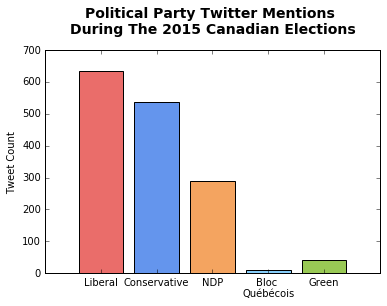

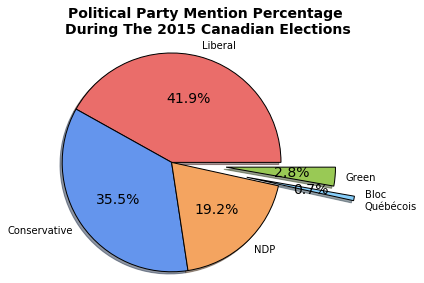

In [15]:
# Plotting the metrics determined for tweet political affiliation.
party_titles = ['Liberal', 'Conservative', 'NDP', 'Bloc \nQuébécois', 'Green']
y_pos = np.arange(len(party_titles))

col = ['#EA6D6A', '#6495ED', '#F4A460', '#87CEFA', '#99C955']

# Bar chart.
plt.bar(y_pos, tweet_party_sum, color = col, align = 'center')
plt.xticks(y_pos, party_titles, fontsize = 10)
plt.ylabel('Tweet Count')
plt.title('Political Party Twitter Mentions \nDuring The 2015 Canadian Elections', fontsize = 14, fontweight = 'bold', y = 1.05)
plt.show()

# Pie chart.
patch, text, auto = plt.pie(tweet_party_sum, labels = party_titles, colors = col, shadow = True, autopct = '%1.1f%%', explode = (0, 0, 0, 0.7, 0.5))
plt.title('Political Party Mention Percentage \nDuring The 2015 Canadian Elections', fontsize = 14, fontweight = 'bold', y = 1.05)
for i in range(0, len(auto)): auto[i].set_fontsize(14)

plt.axis('equal')
plt.show()

From the graphs it's clearer to see that the Liberal party had the most mentions compared to the rest, followed by the Conservatives as what historically happens during the Canadian elections. The NDP also have almost 20% of the tweet mentions. The Bloc Québécois and Green parties both accumilated 0.7% and 2.8% respectively.

Before moving ahead, the sentiment percentage of the classfied tweets dataset is analyzed as well. The figure below shows that the dataset is split into equal parts negative and positive tweets which will be a good basis for model training.

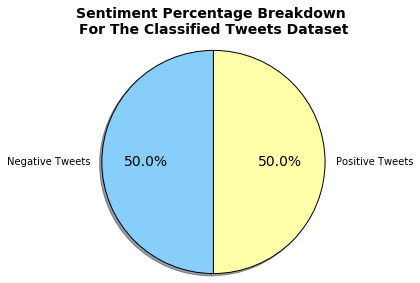

In [16]:
# Plotting the sentiment mentrics for the classified tweets data set.
sent_count = classified_tweets['class'].value_counts()
sent_sum = [sent_count[0], sent_count[4]]

sent_titles = ['Negative Tweets', 'Positive Tweets']

col = ['#87CEFA', '#FFFFAA']

# Pie chart.
patch, text, auto = plt.pie(sent_sum, labels = sent_titles, colors = col, shadow = True, autopct = '%1.1f%%', startangle = 90)
plt.title('Sentiment Percentage Breakdown \nFor The Classified Tweets Dataset', fontsize = 14, fontweight = 'bold', y = 1.05)
for i in range(0, len(auto)): auto[i].set_fontsize(14)

plt.axis('equal')
plt.show()

<br>
## 3. Model Preperation
##### _Preparing the data for logistic regression._

### 3.1 Splitting the Dataset
Here, we use scikit-learn's `train_test_split` funtion in order to define the training and test sets of the classified tweet dataset that will be used for sentiment model training. The training data will use 70% of the original dataset, whereas the remaining 30% will be used for the test set. Thus, $x_n$ represents the tweets, $y_n$ represents the tweet's class, and $n$ represents either training or test sets.

Note that `y_train` is being casted to an intger type to avoid errors during training. 

In [17]:
# Splitting classified dataset into training and test sets
x_train, x_test, y_train, y_test = train_test_split(classified_tweets['text'], classified_tweets['class'], test_size = 0.30)
y_train = y_train.astype('int')

### 3.2 Feature Extraction
Next, we can implement the <i>bag-of-words</i> variable created in Section 1.4, which was an instance of `CountVectorizer`. In order to implement it, we simply feed the $x_n$ data (i.e. the tweets) to the <i>bag-of-words</i>, and it will give us a new set of training and testing data which will be the extracted feature vectors of the original text. As mentioned earlier, the new <i>bag-of-words</i> feature vectors will essentially be the word counts for each unique word in the text documents, or tweets.

Note that the training set is being fit and transformed, whereas the test set is only being transformed. This is becuase the test set is purely needed for checking it's accuracy. 

In [18]:
# Feture vector (bag-of-words) extraction on the training and test sets. 
x_train_BOW = bag_of_words.fit_transform(x_train)
x_test_BOW = bag_of_words.transform(x_test)

The same feature vector extraction is done for the unclassified tweets, as it will also be used for sentiment analysis.

In [19]:
# Feture vector (bag-of-words) extraction on the unclassified dataset. 
unclass_BOW = bag_of_words.transform(unclassified_tweets['text'].values.astype('U'))

### 3.3 Model Initialization
Finally, we call an instance of scikit-learn's `LogisticRegression` function into `model`, which will be used in Section 4.

In [20]:
# Initializing the logistic regression model.
model = LogisticRegression()

<br>
## 4. Model Implementation
##### _Training and testing the logistic regression model._

### 4.1 Training the Model
With numeric representation of the tweets available, we can finally train the logistic regression model. Here, we're training the `model`, created in Section 3.3, using the feature vectors, $x_{BOW}$, and its corresponding classes, $y_{train}$.

In [21]:
# Training the logistic regression model.
model.fit(x_train_BOW, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### 4.2 Testing Trained Model Accuracy
With the `model` trained, the accuracy can be determined by first predicting a new set of classes using the $x_{test}$ set, and comparing it to the actual classes, $y_{test}$. Scikit-learn allows us to obtain model accuracy quickly using the `score` function.

In [22]:
# Checking accuracy level of the trained model. 
class_predicted = model.predict(x_test_BOW)
class_actual = np.array(y_test)
print("Model Accuracy:", (100*model.score(x_test_BOW, y_test)), "%")

Model Accuracy: 76.8483333333 %


Model accuracy will vary from run to run, however the overall average of the accuracy is around 76.5%, which is a good model to use as a baseline in sentiment analysis using other datasets. 

### 4.3 Using the Trained Model for Sentiment Analysis
With a trained sentiment model availalbe, the next objective is to perform some sentiment analysis on the unclassfied tweets. The `predict` function is used once again, except the <i>bag-of-words</i> for the unclassified tweets is fed through instead. Then the total count of both negative and positive tweets for the unclassfied dataset is determined. 

In [23]:
# Predicting the sentiment class of the unclassified dataset using the trained model.
unclass_predicted = model.predict(unclass_BOW)
unclass_count = np.unique(unclass_predicted, return_counts = True)
unclass_array = np.array([[unclass_count[1][0], unclass_count[1][1]]])

# Representing data as a panda to show the head table.
view_total_sent = pd.DataFrame(data = unclass_array, columns = ['Negative Sentiment', 'Positive Sentiment'], index = ['Tweets'])
view_total_sent['Total'] = view_total_sent.sum(axis = 1)
view_total_sent.head()

,Negative Sentiment,Positive Sentiment,Total
Tweets,655,2371,3026


Once again, the sentiment percentage is plotted to view the results visually.

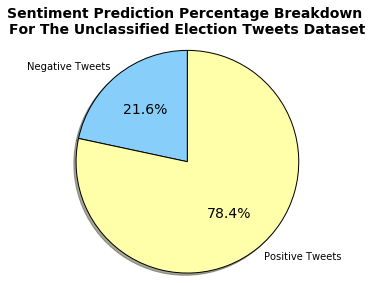

In [24]:
# Plotting the sentiment mentrics for the unclassified tweets data set.
unclass_sent_sum = [unclass_count[1][0], unclass_count[1][1]]

col = ['#87CEFA', '#FFFFAA']

# Pie chart.
patch, text, auto = plt.pie(unclass_sent_sum, labels = sent_titles, colors = col, shadow = True, autopct = '%1.1f%%', startangle = 90)
plt.title('Sentiment Prediction Percentage Breakdown \nFor The Unclassified Election Tweets Dataset', fontsize = 14, fontweight = 'bold', y = 1.05)
for i in range(0, len(auto)): auto[i].set_fontsize(14)

plt.axis('equal')
plt.show()

From the figure above, we see that there is an average of about 80% / 20% split on positive and negative tweets repectively, for the entire dataset.

<br>
## 5. Discussion
##### _"What can public opinion on Twitter tell us about the Canadian political landscape in 2015?"._

### 5.1 Visualizing Political Party Sentiment
From Section 4.3 we know that the general sentiment towards the 2015 election can be thought of as positive. However, knowing just the sentiment metrics of the entire unclassified dataset won't be sufficient to answer the research question. In order to do so, visualizing the the sentiment breakdown for each party will be important.

Therefore, we can use the predicted classes of the unclassified datset, and compare it to each tweet's political affiliation in order to keep track of each political party's sentiments. This is done so below where the sentiment counters for each party are incremented when comparing with the tweet's affiliation, determined in Section 2.1, with the predicted classes. The sentement counters are stored in an $M \times N$ matrix, where $M = 2$ and $N = 5$. The first row of this matrix is the negative sentiment counter, whereas the second row is the positive sentiment counter. Each column represents a political party as seen earlier. The output of the following code block gives the table with each political party sentiment breakdown, and their respective totals.

In [25]:
# Finding sentiment counts for the tweets that were given a political affiliation earlier.
tweet_sent_sum = np.zeros([2, 5])

for i in range(0, 5):
    for j in range(0, len(unclassified_tweets)):
        if((tweet_party_clipped[j, i] == 1) and (unclass_predicted[j] == 0)):
            tweet_sent_sum[0, i] = tweet_sent_sum[0, i] + 1
        
        if((tweet_party_clipped[j, i] == 1) and (unclass_predicted[j] == 4)):
            tweet_sent_sum[1, i] = tweet_sent_sum[1, i] + 1

# Representing data as a panda to show the head table.
view_sent = pd.DataFrame(data = tweet_sent_sum, columns = ['Liberal', 'Conservative', 'NDP', 'Bloc Québécois', 'Green'], index = ['Negative', 'Positive'])
view_sent.loc['Party Total'] = view_sent.sum()
view_sent['Sentiment Total'] = view_sent.sum(axis = 1)
view_sent.head()

,Liberal,Conservative,NDP,Bloc Québécois,Green,Sentiment Total
Negative,192.0,154.0,71.0,2.0,5.0,424.0
Positive,442.0,383.0,219.0,8.0,37.0,1089.0
Party Total,634.0,537.0,290.0,10.0,42.0,1513.0


Once again, with metrics available, the data can be understood better visually. Here we plot a bar chart similar to the one in Section 2.2, where here it's is stacked bar chart showing the sentiment ditribution with respect to the political party's tweet count. 

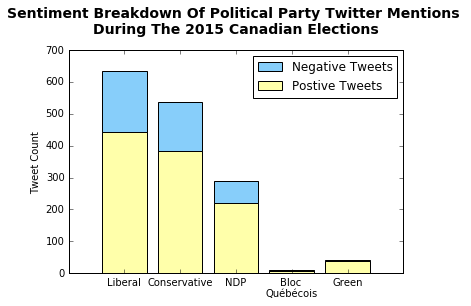

In [26]:
# Plotting the sentiment distribution for political party.
p1 = plt.bar(y_pos, tweet_sent_sum[1, :], color = '#FFFFAA', align = 'center')
p2 = plt.bar(y_pos, tweet_sent_sum[0, :], color = '#87CEFA', align = 'center', bottom = tweet_sent_sum[1, :])

plt.xticks(y_pos, party_titles, fontsize = 10)
plt.ylabel('Tweet Count')
plt.title('Sentiment Breakdown Of Political Party Twitter Mentions \nDuring The 2015 Canadian Elections', fontsize = 14, fontweight = 'bold', y = 1.05)
plt.legend((p2[0], p1[0]), ('Negative Tweets', 'Postive Tweets'))
plt.show()

plt.show()

### 5.2 Summarizing Findings
There is now sufficient information to answer the research question: <i>“What can public opinion on Twitter tell us about the Canadian political landscape in 2015?”</i>. As mentioned earlier, from the figure in Section 4.3, it can be clearly seen that the overall political landscape amongst the public was generally positive, with around an 80/20 positive/negative split. This also supports the findings in Section 5.1, where it can be clearly seen that there is a higher disproportion in positive tweets towards political parties than there are negative. This disproportion is also vaguely close to the 80/20 split from before.

An interesting comparisons can be made with respect to the tweet's political affiliations, and the actual final vote results of the 2015 elections. Both the tweet affiliations and the votes recieved have a very simillar distributions as seen below. Note that the final vote percentages were obtained from CBC's election results, found here: http://www.cbc.ca/includes/federalelection/dashboard/

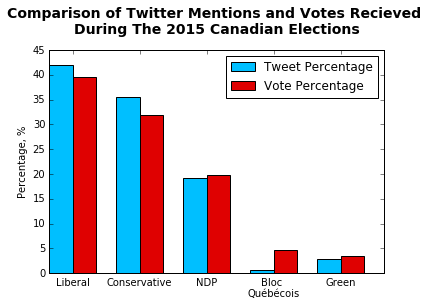

In [27]:
tweet_percentage = 100*np.divide(tweet_party_sum, np.sum(tweet_party_sum))
vote_percentage = [39.5, 31.9, 19.7, 4.7, 3.4]

pt1 = plt.bar(y_pos, tweet_percentage, 0.35, color='#00BFFF')
pt2 = plt.bar(y_pos + 0.35, vote_percentage, 0.35, color='#DF0101')

plt.xticks(y_pos + 0.35, party_titles, fontsize = 10)
plt.ylabel('Percentage, %')
plt.title('Comparison of Twitter Mentions and Votes Recieved \nDuring The 2015 Canadian Elections', fontsize = 14, fontweight = 'bold', y = 1.05)
plt.legend((pt1[0], pt2[0]), ('Tweet Percentage', 'Vote Percentage'))
plt.show()

plt.show()

The figure above shows the stark similarity in the distribution in Twitter mentions and the actual election results. This can suggest that Twitter is indeed a very good representation of how people will vote in election settings. Note that votes alone won't suggest the outcome of an election, but factoring in the sentiment for each party will help with doing so. Luckily for us, the analysis consistently revealed more positive sentiment towards each party than negative, so the percentage distribution of postive tweets, and the overall tweets can be used interchangeably for rough estimates. 

The only party that doesn't correlate here is the Bloc Québécois which can be attributed to the possibility that most of the tweets about the BQ are in French and went unnoticed during the buzz word search. Another possiblilty could be that the Québec sepratist movement is predominantly supported by an older generation that doesn't have a twitter presence.

From the results obtained throughout the assignment, it can be concluded that having a <i>postive</i> social media presence is essential in order to engage with today's voters.